<a href="https://colab.research.google.com/github/Khaled97Otour/Computer-aid-diagnostic-system-to-predict-and-extract-Lung-Cancer/blob/main/Lung_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Pixel Size
The pixel size can be calculated by dividing the DFOV
in mm by 512 (the matrix). The depth the pixel
represents is determined by the slice thickness.
PIXEL SIZE IN MILLIMETERS
DFOV in cm and mm 512x512

10 cm, 100 mm 0.20

15 cm, 150 mm 0.29

20 cm, 200 mm 0.39

22 cm, 220 mm 0.43

25 cm, 250 mm 0.49

30 cm, 300 mm 0.59

35 cm, 350 mm 0.68

40 cm, 400 mm 0.78

44 cm, 440 mm 0.86

50 cm, 500 mm 0.98


In [ ]:
pip install -U scikit-fuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 993 kB 3.9 MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894089 sha256=43450b0587516b46b339bbaca80db5b956aacbb5ba7f139383286a2d0ce67835
  Stored in directory: /root/.cache/pip/wheels/d5/74/fc/38588a3d2e3f34f74588e6daa3aa5b0a322bd6f9420a707131
Successfully built scikit-fuzzy


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import math
import cv2
from skimage import measure
import skfuzzy
import numpy as np
import matplotlib.pyplot as plt
class Lung:
  def __init__(self, lung_image_name):
    self.lung_image_name = lung_image_name 
    self.Width  = 512
    self.height = 512
    print("Create {} as Lung Class".format(self.lung_image_name))

  def reading_Image(self):
    img= cv2.imread('{}'.format(self.lung_image_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (self.Width,self.height))
    return img
  
  def Colored_image(self):
    img= cv2.imread('{}'.format(self.lung_image_name))
    img= cv2.resize(img, (self.Width,self.height))
    return img
  
  def Img_fill(self,IMAGE):
    BW = IMAGE.astype('uint8')
    kernel  = np.ones((11,11),np.uint8)
    BW = cv2.dilate(BW,kernel,iterations = 1)
    kernel1  = np.ones((8,8),np.uint8)
    BW = cv2.dilate(BW,kernel1,iterations = 1)
    im_floodfill = BW.copy()
    h, w = BW.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(im_floodfill, mask, (0,0), 255);
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    im_out = BW | im_floodfill_inv
    return im_out

  def applying_mask(self):
    image=Lung.reading_Image(self)
    mask = image.copy()
    mask1 = image.copy()
    for i in range (self.Width):
        for j in range (self.height):
            z= math.sqrt((i-512/2)**2+(j-512/2)**2)
            if z <=150 :
                mask [i][j]=255
            else :
                mask [i][j]=0  
    for i in range (self.Width):
        for j in range (self.height):
            if i>=130 and i<=380 :
                mask1 [i][j]=255
            else :
                mask1 [i][j]=0 
    ret, bw_img = cv2.threshold(image,127,256,cv2.THRESH_BINARY)
    bw_img1 = bw_img
    for i in range (self.Width):
        for j in range (self.height):
            bw_img1[i][j] = 255-bw_img[i][j]
            if mask[i][j] > 0 and bw_img1[i][j] > 0 and mask1[i][j]>0:
                bw_img[i][j] = 255 
            else : 
                bw_img[i][j] = 0
    masked_image = bw_img
    return masked_image

  def CCL(self):
    bw_img1=Lung.applying_mask(self)
    label = measure.label((bw_img1))
    propsa = measure.regionprops(label)
    x = []
    for i in propsa:
      x.append(i.area)
    x = np.asarray(x)
    for i in range(len(propsa)):
      j=i+1
      for j in range(len(propsa)):
        if x[i]>x[j]:
          x1   = x[j]
          x[j] = x[i]
          x[i] = x1
    u = 0
    v = 0
    for i in range(len(x)-1):
      z=x[i]-x[i+1]
      j=i+1
      if (x[i]>=2500)and(x[i]<=40000):
        if(x[i+1]>=0)and(x[i+1]<=40000):
          if (z<=30000)and(z>=500):
            u=x[i]
            v=x[i+1]
            break
    y1=0
    y2=0
    for i in propsa:
      if i.area== u:
        y1=i.label
    for i in propsa:
      if i.area== v:
        y2=i.label
    x=[y1,y2]
    return label, x ,bw_img1

  def Calculate_area(self,Image):
    if Image.shape[2] > 1:
      Image = cv2.cvtColor(Image, cv2.COLOR_BGR2GRAY)
    Image = Lung.Img_fill(self,Image)
    Image = measure.label((Image))
    propsa = measure.regionprops(Image)
    area=[]
    for i in propsa:
      area.append(i.area)
    area=np.asarray(area)
    return area

  def Right_lung_Display(self,x=None):
    print("the Right side of the lung:")
    image,label,bw_img=Lung.CCL(self)
    BW = bw_img
    for i in range (self.Width):
      for j in range (self.height):
        if image[i][j]==label[0] :
          BW[i][j]=bw_img[i][j]
        else :
          BW[i][j]=0
    im_out = Lung.Img_fill(self,BW)
    img_rgb = Lung.Colored_image(self)
    right_lung = img_rgb
    for i in range (self.Width):
      for j in range (self.height):
        if im_out[i][j] == 0 :
          right_lung[i][j]=0
        else :
          right_lung[i][j]=img_rgb[i][j]
    area = Lung.Calculate_area(self,right_lung)
    print("The area of the right lung is {} CM^2\n".format(area.max()*0.00685))
    return plt.imshow(right_lung)

  def Left_lung_Display(self):
    print("the Left side of the lung:")  
    image,label,bw_img=Lung.CCL(self)
    BW=image
    for i in range (self.Width):
      for j in range (self.height):
        if image[i][j]==label[1] :
          BW[i][j]=bw_img[i][j]
        else :
          BW[i][j]=0 
    im_out = Lung.Img_fill(self,BW)
    img_rgb = Lung.Colored_image(self)
    Left_lung = img_rgb
    for i in range (self.Width):
      for j in range (self.height):
        if im_out[i][j] == 0 :
          Left_lung[i][j]=0
        else :
          Left_lung[i][j]=img_rgb[i][j] 
    area = Lung.Calculate_area(self,Left_lung)
    print("The area of the Left lung is {} CM^2\n".format(area.max()*0.00685))
    return plt.imshow(Left_lung)   

  def Lungs_Display(self):
    print('the segment lungs:')
    image,label,bw_img = Lung.CCL(self)
    BW=image
    for i in range (self.Width):
      for j in range (self.height):
        if image[i][j]==label[0] or image [i][j]==label[1]:
          BW[i][j]=bw_img[i][j]
        else :
          BW[i][j]=0
    im_out = Lung.Img_fill(self,BW)
    img_rgb = Lung.Colored_image(self)
    lungs = img_rgb
    for i in range (self.Width):
      for j in range (self.height):
        if im_out[i][j] == 0 :
          lungs[i][j]= 0
        else :
          lungs[i][j]= img_rgb[i][j]
    area = Lung.Calculate_area(self,lungs)
    if area.shape[0] > 1:
      print("The area of the lungs are {} CM^2\n".format((area[0]+area[1])*0.00685))
    else: 
      print("The area of the lungs are {} CM^2\n".format(area[0]*0.00685))
    return plt.imshow(lungs)
  
  def Segmentation(self):
    image,label,bw_img = Lung.CCL(self)
    BW=image
    for i in range (self.Width):
      for j in range (self.height):
        if image[i][j]==label[0] or image [i][j]==label[1]:
          BW[i][j]=bw_img[i][j]
        else :
          BW[i][j]=0
    im_out = Lung.Img_fill(self,BW)
    a      = Lung.reading_Image(self)
    for i in range (self.Width):
        for j in range (self.height):
            if im_out [i][j] > 0 :
                BW[i][j]=a[i][j]
            else :
                BW[i][j]=0
    BW = BW/255
    imdata = np.reshape(BW, ( 1,262144))
    o = skfuzzy.cluster.cmeans(imdata, 3, 2, 0.0001, 1000000, init=None, seed=None)
    nn = o[1]
    N1 = []
    N2 = []
    N3 = []
    j  = o[1].shape[0]
    h  = o[1].shape[1]
    for i in range (j):
      for j in range (h):
        if i == 0:
          N1.append(nn[0][j])
        if i == 1:
          N2.append(nn[1][j])
        if i == 2:
          N3.append(nn[2][j])
    N1 = np.asarray(N1)
    c1 = sum(N1) / N1.shape[0]
    N2 = np.asarray(N2)
    c2 = sum(N2) / N2.shape[0]
    N3 = np.asarray(N3)
    c3 =sum(N3)/N3.shape[0]
    N = np.array([N1,N2,N3])
    C  = np.array([c1,c2,c3])
    C1 = -np.sort(-C)
    X  = []
    for i in range(len(C1)):
      for k in range(len(C)):
        if C1[i] == C[k]:
          XX = []
          for o in range (N.shape[1]):
            XX.append(N[k][o])
          X.append(XX)
        else: 
          continue 
    X  = np.asarray(X) 
    X1 = X[0]
    X2 = X[1]
    X3 = X[2]

    imdx1     =   np.reshape(X1, (self.Width, self.height))
    imdx2     =   np.reshape(X2, (self.Width, self.height))
    imdx3     =   np.reshape(X3, (self.Width, self.height))
    imdx4     =   imdx3
    kernel1   =   np.ones((5,5),np.uint8)
    kernel2   =   np.ones((3,4),np.uint8)
    kernel3   =   np.ones((4,3),np.uint8)
    for i in range (self.Width):
      for j in range (self.height):
        if imdx3[i][j]<0.5:
          imdx3[i][j]=0
        if imdx3[i][j]>0.5:
          imdx3[i][j]=255
    kernel4   =   np.ones((3,3),np.uint8)
    imdx3     =   cv2.morphologyEx(imdx3, cv2.MORPH_CLOSE, kernel4)
    imdx3     =   cv2.morphologyEx(imdx3, cv2.MORPH_OPEN, kernel1)
    imdx3     =   cv2.erode(imdx3,kernel2,iterations = 1)
    imdx3     =   cv2.erode(imdx3,kernel3,iterations = 1)
    imdx3     =   cv2.morphologyEx(imdx3, cv2.MORPH_OPEN, kernel4)
    Segmentation = []
    Segmentation.append(imdx1)
    Segmentation.append(imdx2)
    Segmentation.append(imdx3)
    Segmentation.append(imdx4)
    return Segmentation

  def Tumor_processing(self,Image,unclear_image):
    img_rgb = Lung.Colored_image(self)
    labele  = measure.label((Image))
    propsa1 = measure.regionprops(labele)
    area  = []
    major_axis_length = []
    minor_axis_length = []
    for i in propsa1:
        area.append(i.area)
        major_axis_length.append(i.major_axis_length)
        minor_axis_length.append(i.minor_axis_length)
        l=i
    area  = np.asarray(area)
    major_axis_length = np.asarray(major_axis_length)
    minor_axis_length = np.asarray(minor_axis_length)
    y  = []
    for i in propsa1:
      y.append(i.label)
    y = np.asarray(y)
    y1 = 0
    mm=0.0
    float(mm)
    for i in range (len(propsa1)):
      mm = minor_axis_length[i] / major_axis_length[i]
      if mm >0.50:
        if area[i] < 2000 :
          if area[i] > 40:
            y1= y[i] 
            break
          continue
      continue
    B1=Image.copy().astype('uint8')
    for i in range (self.Width):
      for j in range (self.height):
        if labele[i][j]==y1 :
          B1[i][j]=Image[i][j]
        else :
          B1[i][j]=0
    kernel    =   np.ones((10,10),np.uint8)
    B1        = cv2.dilate(B1,kernel,iterations = 1)
    for i in range (self.Width):
      for j in range (self.height):
        if B1[i][j] > 0 :
          B1[i][j]=unclear_image[i][j]
        else :
          B1[i][j]=0
    return B1

  def Tumor_display(self,Image,unclear_image):
    B1 = Lung.Tumor_processing(self,Image,unclear_image)
    Image = measure.label((B1))
    propsa = measure.regionprops(Image)
    area=[]
    major_axis_length = []
    minor_axis_length = []
    for i in propsa:
      area.append(i.area)
      major_axis_length.append(i.major_axis_length)
      minor_axis_length.append(i.minor_axis_length)
    area  = np.asarray(area)
    major_axis_length = np.asarray(major_axis_length)
    minor_axis_length = np.asarray(minor_axis_length)
    img_rgb = Lung.Colored_image(self)
    for i in range(self.Width):
      for j in range(self.height):
        if (B1[i,j]>0):
          img_rgb[i,j,0]=255
          img_rgb[i,j,1]=0
          img_rgb[i,j,2]=0
    print("the tumor size is {} CM^2".format(area[0]*0.00685))
    print("the major axis length of the tumor is {} CM".format(major_axis_length[0]*0.0685))
    print("the minor axis length of the tumor is {} CM\n".format(minor_axis_length[0]*0.0685))
    return plt.imshow(img_rgb)
  
  def plot_3D_Tuomr(self,N_Image,N_unclear_image):
    X = []
    for i in range(N_Image.shape[0]):
      X.append(Lung.Tumor_processing(self,N_Image[i],N_unclear_image[i]))
    X = np.asarray(X)
    X = np.transpose(X)
    fig = plt.figure(figsize=(10, 10))

    # Generating a 3D sine wave
    ax = plt.axes(projection='3d')
    ax.voxels(X, facecolors='red')
    pass

In [ ]:
lung =Lung(r'/content/drive/MyDrive/Colab Notebooks/Lungs images/t1.jpg')

Create /content/drive/MyDrive/Colab Notebooks/Lungs images/t1.jpg as Lung Class


In [ ]:
b = lung.Colored_image()
b.shape

(512, 512, 3)

the Right side of the lung:
The area of the right lung is 223.7347 CM^2



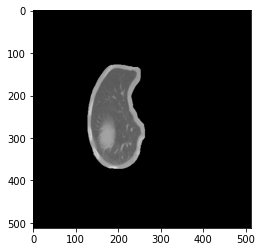

In [ ]:
lung.Right_lung_Display()

the Left side of the lung:
The area of the Left lung is 185.41580000000002 CM^2



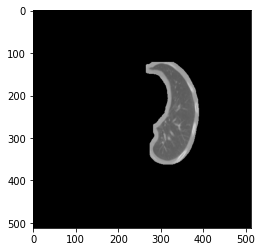

In [ ]:
lung.Left_lung_Display()

the segment lungs:
The area of the lungs are 439.32475 CM^2



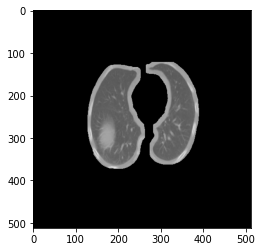

In [ ]:
lung.Lungs_Display()

In [ ]:
Segmentation = lung.Segmentation()

In [ ]:
a= lung.Tumor_processing(Segmentation[2],Segmentation[3])

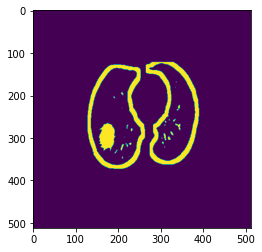

In [ ]:
plt.imshow(Segmentation[0])

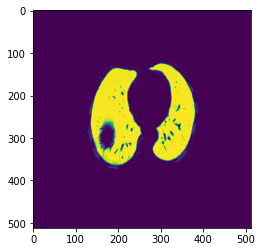

In [ ]:
plt.imshow(Segmentation[1])

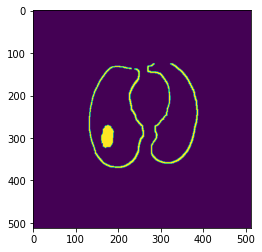

In [ ]:
plt.imshow(Segmentation[2])

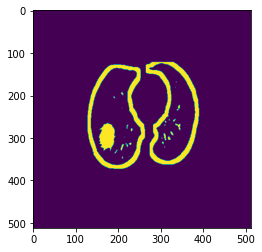

In [ ]:
plt.imshow(Segmentation[3])

the tumor size is 11.89845 CM^2
the major axis length of the tumor is 4.27898032051062 CM
the minor axis length of the tumor is 2.4508489090916923 CM



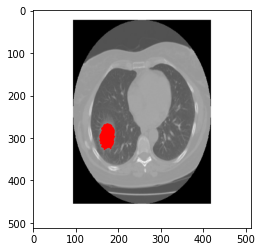

In [ ]:
lung.Tumor_display(Segmentation[2],Segmentation[3])

In [ ]:
X=[]
for i in range(10):
  X.append(lung.Segmentation())
X=np.asarray(X)
X.shape

(10, 4, 512, 512)

In [ ]:
Y=X[:,2,:,:]
Z=X[:,3,:,:]

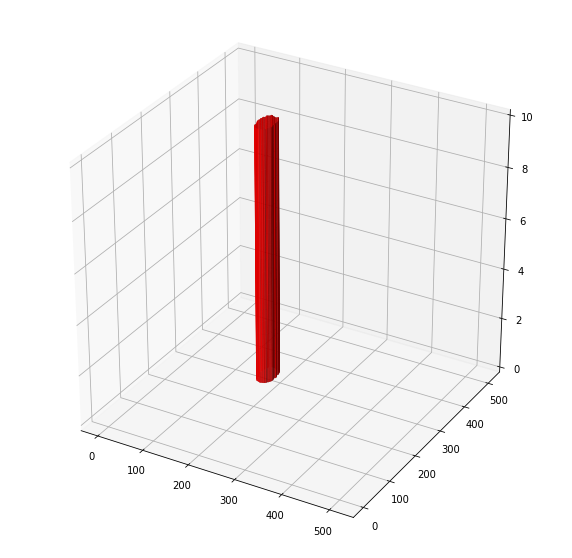

In [ ]:
# testing the plot Function
lung.plot_3D_Tuomr(Y,Z)